In [ ]:
# default_exp model_fitting

# CMR-DE Generalization Tests
Does adding a differential encoding mechanism improve CMR's capacity to generalize across conditions of the Lohnas (2014) dataset? To find out, we'll fit CMR and CMR-DE at the group and individual level to conditions of the Lohnas (2014) dataset and apply the fitted models' to predict data from held-out conditions. 

The Lohnas (2014) dataset contains data from the following conditions:

1. Control lists that contained all once-presented items;  
2. pure massed lists containing all twice-presented items; 
3. pure spaced lists consisting of items presented twice at lags 1-8, where lag is defined as the number of intervening items between a repeated item's presentations; 
4. mixed lists consisting of once presented, massed and spaced items. Within each session, subjects encountered three lists of each of these four types. 

In each list there were 40 presentation positions, such that in the control lists each position was occupied by a unique list item, and in the pure massed and pure spaced lists, 20 unique words were presented twice to occupy the 40 positions. In the mixed lists 28 once-presented and six twice-presented words occupied the 40 positions. In the pure spaced lists, spacings of repeated items were chosen so that each of the lags 1-8 occurred with equal probability. In the mixed lists, massed repetitions (lag=0) and spaced repetitions (lags 1-8) were chosen such that each of the 9 lags of 0-8 were used exactly twice within each session. The order of presentation for the different list types was randomized within each session. For the first session, the first four lists were chosen so that each list type was presented exactly once. An experimenter sat in with the subject for these first four lists, though no subject had difficulty understanding the task.

If, as we predict, CMR-DE generalizes better across Lohnas (2015) conditions than the original model, that will be powerful evidence that the original model isn't a sufficient account of repetition and spacing effects in free recall, if paired with an analysis of precisely how the model fails and exploration of the extended model's novel predictions.

## Initial Fitting Between Subjects
For each condition and subject, find the best fit parameters for the CMR model.

In [1]:
from compmemlearn.fitting import apply_and_concatenate, cmr_rep_objective_function, cmr_rep_likelihood
from compmemlearn.datasets import prepare_lohnas2014_data, simulate_data
from compmemlearn.analyses import recall_probability_by_lag
import pandas as pd
from psifr import fr
from scipy.optimize import differential_evolution
from numba.typed import List
import numpy as np

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,condition
0,1,1,0,1,1.0,True,True,0,False,4
1,1,1,1,2,2.0,True,True,0,False,4
2,1,1,2,3,3.0,True,True,0,False,4
3,1,1,3,4,4.0,True,True,0,False,4
4,1,1,4,5,5.0,True,True,0,False,4


In [2]:
from scipy.optimize import differential_evolution
from numba.typed import List

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'familiarity_scale']

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub)
]

In [3]:
# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model

individual_cmrde_results = [[], [], [], []]

for type_index, list_type in enumerate([1, 2, 3, 4]):
    for subject in np.unique(subjects):
        print(list_type, subject)

        selection = np.logical_and(list_types == list_type, subjects == subject)

        # cost function to be minimized
        # ours scales inversely with the probability that the data could have been 
        # generated using the specified parameters and our model
        cost_function = cmr_rep_objective_function(
            trials[selection], presentations[selection], list_types[selection], list_length,
            {'sampling_rule': 0}, free_parameters)

        individual_cmrde_results[type_index].append(differential_evolution(cost_function, bounds, disp=False))
        print(individual_cmrde_results[type_index][-1].fun)

1 1
690.2456620646954
1 2
409.72698857954754
1 3
689.3571036654557
1 4
280.81400850338963
1 5
666.7345700371222
1 6
635.9957383344124
1 7
322.94632349396034
1 8
599.0876166495319
1 10
467.9340635181846
1 11
843.1469919989017
1 12
685.2589001621639
1 13
759.2152928705614
1 14
894.7711159975086
1 15
477.6057749732166
1 16
578.1515129451082
1 17
543.7283883832471
1 18
554.654611945429
1 19
529.6608391205107
1 20
367.9589338530243
1 21
557.5543963225296
1 22
382.8958576803908
1 23
354.8858287383165
1 24
415.52607929288456
1 25
597.5321365112277
1 27
352.43162123653497
1 28
296.34778382239784
1 29
468.0270374670414
1 30
371.3404168634894
1 31
424.60840149500405
1 32


KeyboardInterrupt: 

In [ ]:
for_df = []
list_type_labels = ['control', 'massed', 'spaced', 'mixed']

for list_type, condition in enumerate(individual_cmrde_results):

    for subject_index, subject in enumerate(condition):

        for_df.append([list_type_labels[list_type], subject_index, subject.fun] + subject.x.tolist())

param_df = pd.DataFrame(for_df, columns = ['condition', 'subject', 'likelihood'] + free_parameters)
param_df.to_csv('../../data/lohnas_2014_individual_cmrde_results.csv')

param_df

## Are Fitted Parameter Value Distributions More or Less Similar Across Conditions?

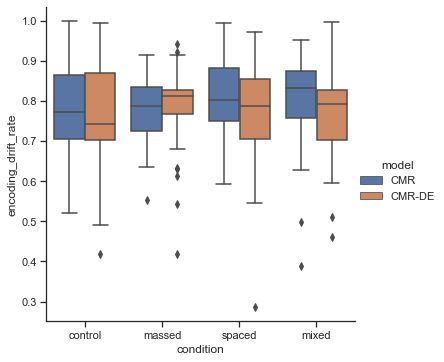

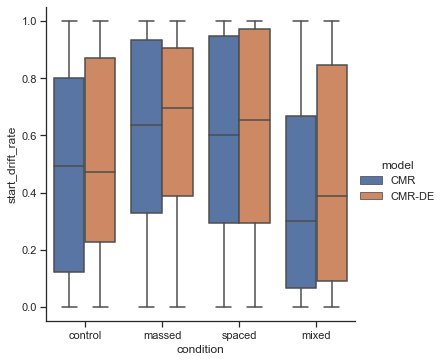

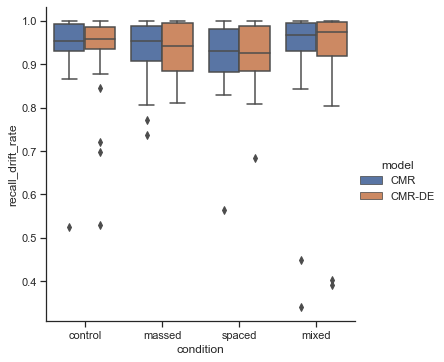

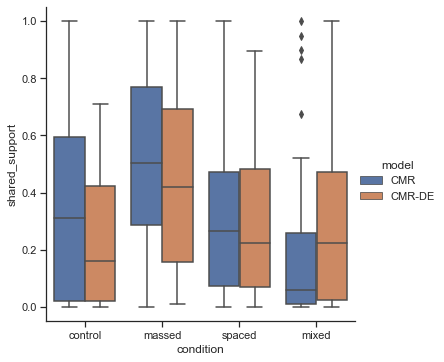

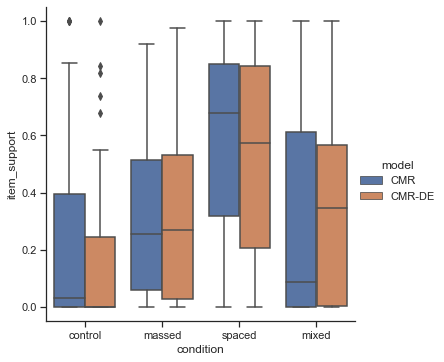

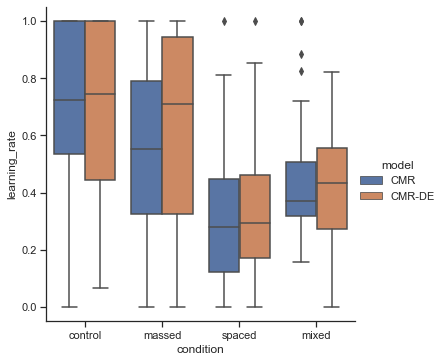

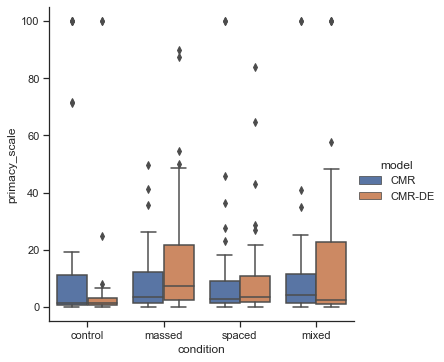

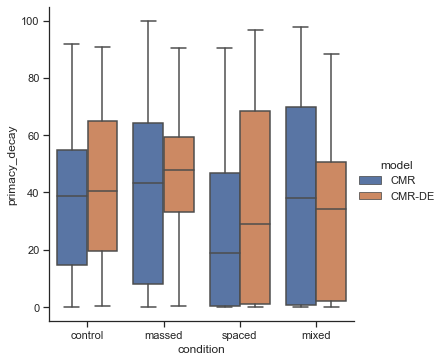

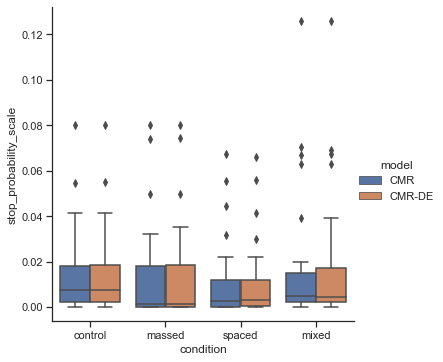

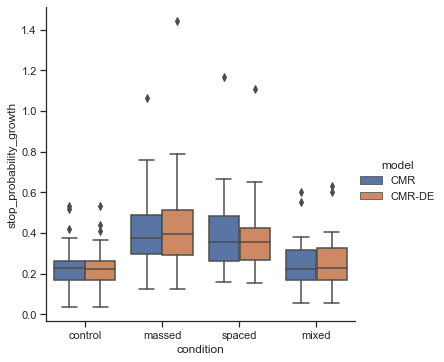

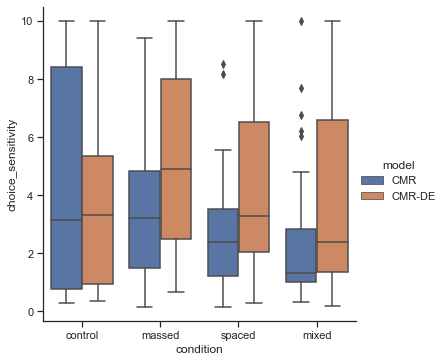

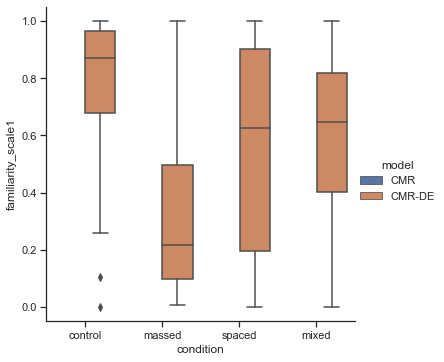

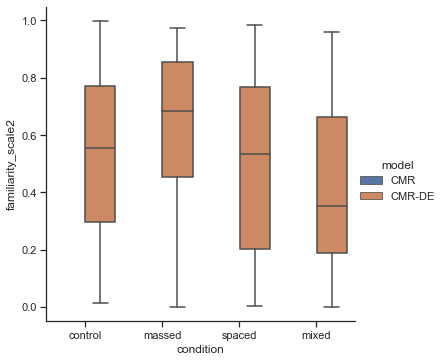

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

original_param_df = pd.read_csv('../../data/lohnas_2014_individual_cmr_results.csv')
de_param_df = pd.read_csv('../../data/lohnas_2014_individual_cmrde_results.csv')

param_df = pd.concat([original_param_df, de_param_df], keys=['CMR', "CMR-DE"], names=['model']).reset_index()

sns.set_theme(style="ticks")

for parameter in free_parameters:
    g = sns.catplot(x="condition", y=parameter, data=param_df, kind='box', hue='model')
    plt.show()

Not quite what we were expecting. The extra differential encoding mechanism does not seem to have any substantial effect on the fitted parameter distributions. Furthermore, the fitted familiarity_scale parameters are not consistent between conditions in the way I hoped. But we need to do more robust tests to determine if this is really a dint on our candidate account.

## Are Fits Better?
Here we want to import fits from the original CMR model and focus analysis on the distribution of log-likelihood scores for each fitted parameter configuration.

Text(18.50026666666667, 0.5, 'log-likelihood of data given model')

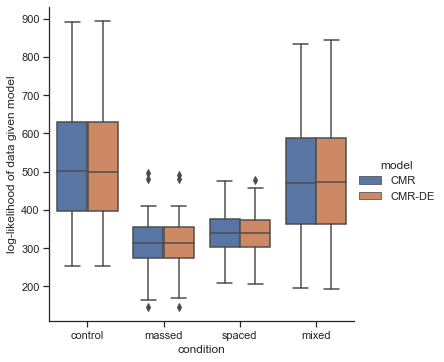

In [6]:
g = sns.catplot(x="condition", y='likelihood', data=param_df, kind='box', hue='model')
plt.ylabel('log-likelihood of data given model')

## Is Generalization Between Conditions Better?
Compute the log-likelihood for one condition using parameters fitted from another.

In [13]:
# for each condition, subject, and model
# track the likelihood of all other conditions given the subject and model
generalization_results = []
for type_index, list_type in enumerate(['control', 'massed', 'spaced', 'mixed']):
    for subject in pd.unique(param_df.subject):
        for model in ['CMR', 'CMR-DE']:

            # grab parameters for this model and subject and condition
            row = param_df.loc[(param_df.condition == list_type) & (param_df.subject == subject) & (param_df.model == model)].values.tolist()[0][6:]

            # enforce familiarity_scale to 0 if it was never fitted
            if np.isnan(row[-1]):
                row[-1] = 1
                row[-2] = 1

            # add sampling rule configuration
            row.append(0)

            generalization_results.append([list_type, subject, model])
            for condition in [1, 2, 3, 4]:

                # compute log-likelihood of this condition given these parameters
                selection = np.logical_and(list_types == condition, subjects == subject+1)
                likelihood = cmr_rep_likelihood(
                    trials[selection],
                    presentations[selection],
                    list_types[selection], list_length, *row)

                # add to dataframe
                generalization_results[-1].append(likelihood)

In [28]:
row

[0.7862721253928443,
 0.0597822157714102,
 0.999308073019236,
 0.4292437993875368,
 2.220446049250313e-16,
 0.4933666709655375,
 22.74443072260201,
 40.58707757498827,
 0.0670281276025422,
 0.218871795663229,
 4.479562486056612,
 1000000,
 0]

In [29]:
row = [0.832824648976199,
 0.0416888292202337,
 0.9599582368645856,
 0.781888765456461,
 2.220446049250313e-16,
 0.6506191900092523,
 20.018430522432496,
 19.25617740121621,
 0.0670371888572209,
 0.2188354396101868,
 10,
 10.0,
 0]

cmr_rep_likelihood(
                    trials[selection],
                    presentations[selection],
                    list_types[selection], list_length, *row)

1206.5073683781789

In [14]:
gen_df = pd.DataFrame(generalization_results, columns=['condition', 'subject', 'model', 'control', 'massed', 'spaced', 'mixed'])

gen_df.to_csv('../../data/lohnas_2014_generalization_results.csv')

gen_df

,condition,subject,model,control,massed,spaced,mixed
0,control,0,CMR,691.362330,320.765610,375.007733,607.689160
1,control,0,CMR-DE,691.512371,318.726229,372.692533,591.210324
2,control,1,CMR,409.724560,288.905012,366.234154,447.508332
3,control,1,CMR-DE,409.724856,288.863714,368.731381,452.711456
4,control,2,CMR,689.702973,427.020955,452.457173,629.422013
...,...,...,...,...,...,...,...
275,mixed,32,CMR-DE,476.979956,374.721026,351.739561,485.824196
276,mixed,33,CMR,602.532326,360.022526,428.677751,595.407775
277,mixed,33,CMR-DE,595.989041,358.321664,428.603684,579.209334
278,mixed,34,CMR,1447.983146,626.037923,876.000818,1046.033025


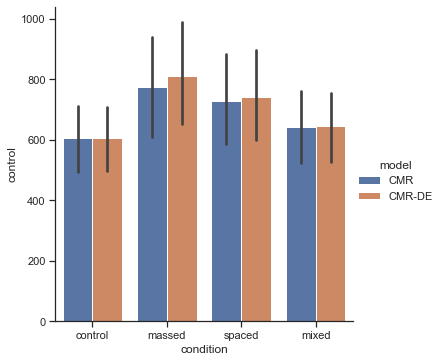

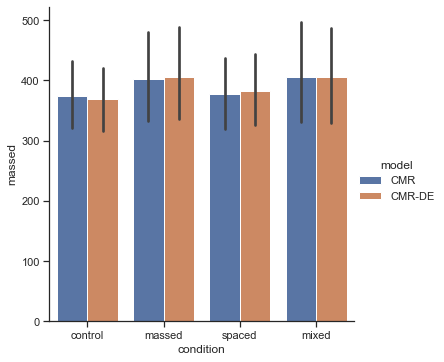

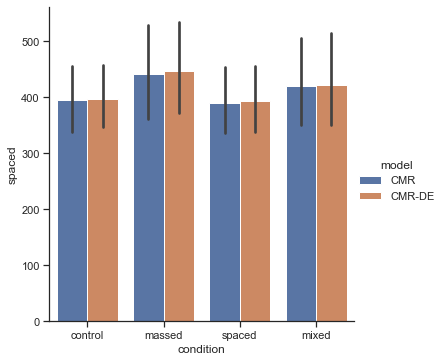

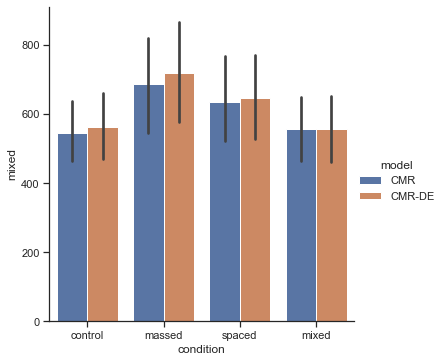

In [15]:
sns.set_theme(style="ticks")

for predicted in ['control', 'massed', 'spaced', 'mixed']:
    g = sns.catplot(x="condition", y=predicted, data=gen_df, kind='bar', hue='model')
    plt.show()